In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
pd.options.mode.chained_assignment = None

In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

In [3]:
mnist

{'data': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'target': array([0, 0, 0, ..., 9, 9, 9], dtype=int8),
 'feature_names': ['pixel1',
  'pixel2',
  'pixel3',
  'pixel4',
  'pixel5',
  'pixel6',
  'pixel7',
  'pixel8',
  'pixel9',
  'pixel10',
  'pixel11',
  'pixel12',
  'pixel13',
  'pixel14',
  'pixel15',
  'pixel16',
  'pixel17',
  'pixel18',
  'pixel19',
  'pixel20',
  'pixel21',
  'pixel22',
  'pixel23',
  'pixel24',
  'pixel25',
  'pixel26',
  'pixel27',
  'pixel28',
  'pixel29',
  'pixel30',
  'pixel31',
  'pixel32',
  'pixel33',
  'pixel34',
  'pixel35',
  'pixel36',
  'pixel37',
  'pixel38',
  'pixel39',
  'pixel40',
  'pixel41',
  'pixel42',
  'pixel43',
  'pixel44',
  'pixel45',
  'pixel46',
  'pixel47',
  'pixel48',
  'pixel49',
  'pixel50',
  'pixel51',
  'pixel52',
  'p

In [4]:
X , y = mnist['data'], mnist['target']
X.shape, y.shape #784 features #each image 28*28 pixels. each feature represents one pixels intensity
#from 0-white to 255-black

((70000, 784), (70000,))

4

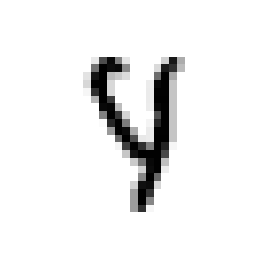

In [5]:
some_digit = X[25000]

some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show
y[25000]

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]
y_train_5 = (y_train==5)
y_test_5 = (y_test==5) #for binary classifier

In [7]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=15, random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=15,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [8]:
sgd_clf.predict([some_digit])

array([False])

In [9]:
#Manual Cross Validation

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred==y_test_fold)
    print(n_correct/len(y_pred))

0.96025
0.9575
0.954


In [10]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.96025, 0.9575 , 0.954  ])

In [11]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

In [12]:
np.zeros((len(X),1),dtype=bool)

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.909  , 0.90715, 0.9128 ])

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

In [22]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)
#Only 82% accurate in detecting 5s and detects only 70% of the 5s

(0.753731343283582, 0.7825124515771997)

In [23]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7678522943252782

In [24]:
y_scores = sgd_clf.decision_function([some_digit]) #decision score for this instance
y_scores

array([-31971.55433473])

In [25]:
threshold = 0
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([False])

In [26]:
#SGD uses a threshold = 0 so the result is same as predict funtion

In [27]:
some_digit = X[36000]
y_scores = sgd_clf.decision_function([some_digit]) #decision score for this instance
y_scores
threshold = 0
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([ True])

In [28]:
some_digit = X[36000]
y_scores = sgd_clf.decision_function([some_digit]) #decision score for this instance
y_scores
threshold = 200000
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([False])

In [29]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function') 
#returns decision scores for all instances instead of class predictions

In [30]:
#now we can plot a precision_recall_curve using these scores
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

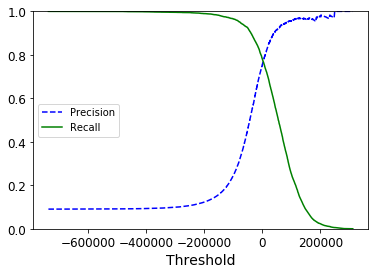

In [31]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center left')
    plt.ylim([0,1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

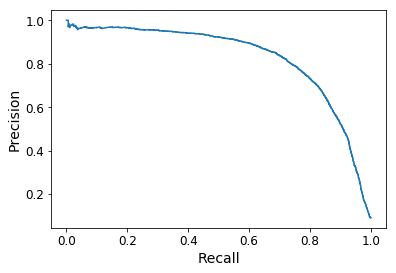

In [32]:
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.plot(recalls, precisions)
plt.show()

In [33]:
y_train_pred_95 = (y_scores>70000) #to get a precision of 95% we can use a custom threshold to predict classes from decision 
#scores instead of predict function 

In [34]:
precision_score(y_train_5, y_train_pred_95), recall_score(y_train_5, y_train_pred_95)

(0.9389438943894389, 0.41984873639549897)

In [35]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [36]:
def plot_roc_curver(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

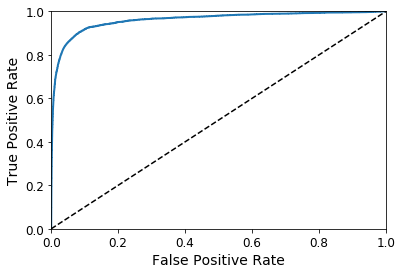

In [37]:
plot_roc_curver(fpr, tpr)
plt.show() #tpr=recall

In [38]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9606704076464168

In [39]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

rf_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(rf_clf, X_train, y_train_5, cv=3, method='predict_proba')

C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [40]:
y_scores_forest = y_probas_forest[:,1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_train_5, y_scores_forest)

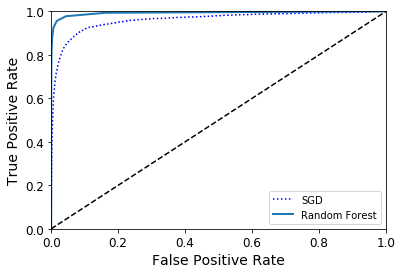

In [41]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curver(fpr_rf, tpr_rf, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [42]:
roc_auc_score(y_train_5, y_scores_forest)

0.9931243366003829

In [43]:
y_pred_rf = cross_val_predict(rf_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_pred_rf), recall_score(y_train_5, y_pred_rf)

C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


(0.9852973447443494, 0.8282604685482383)

In [44]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=int8)

In [45]:
some_digit_scores = sgd_clf.decision_function([some_digit]) #returns decision score for each class
some_digit_scores

array([[ -89954.97717285, -165172.20945883, -137335.10524126,
         -47273.32317099,  -83798.14382258,   50071.53339345,
        -259588.46135634,  -75405.39389259, -278921.65760995,
        -228953.4477755 ]])

In [46]:
np.argmax(some_digit_scores)

5

In [47]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [48]:
sgd_clf.classes_[5]

5

In [49]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=15, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict(([some_digit]))

array([5], dtype=int8)

In [50]:
len(ovo_clf.estimators_)

45

In [51]:
rf_clf.fit(X_train, y_train)
rf_clf.predict([some_digit])

C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([5], dtype=int8)

In [52]:
rf_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

In [53]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.84563087, 0.85659283, 0.85672851])

In [54]:
#scaling improves accuracy to 90%
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.91246751, 0.9119456 , 0.90913637])

In [55]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5729,    2,   21,    8,   11,   42,   50,    8,   48,    4],
       [   1, 6479,   42,   21,    6,   48,    5,   12,  118,   10],
       [  42,   37, 5337,  100,   86,   25,   94,   54,  170,   13],
       [  41,   38,  133, 5352,    1,  233,   33,   55,  150,   95],
       [  18,   24,   38,   10, 5352,    8,   54,   34,   91,  213],
       [  62,   41,   34,  188,   68, 4602,  106,   31,  196,   93],
       [  31,   27,   41,    2,   40,   89, 5622,    8,   57,    1],
       [  22,   18,   74,   25,   52,   12,    5, 5809,   21,  227],
       [  44,  140,   64,  142,    8,  152,   55,   22, 5100,  124],
       [  38,   32,   28,   86,  152,   36,    2,  195,   91, 5289]],
      dtype=int64)

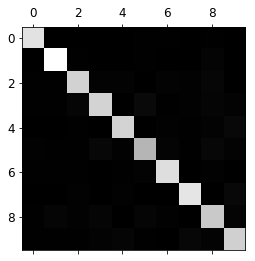

In [56]:
ax = plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [57]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

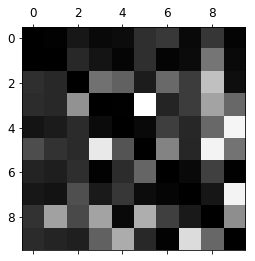

In [58]:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

In [59]:
from sklearn.neighbors import KNeighborsClassifier #Supports Multilabel Classification

y_train_large = (y_train>=7)
y_train_odd = (y_train%2==1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [60]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [62]:
#computes average F1 score across all labels

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=2)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.974920556149222

In [61]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [74]:
#clean the classifier to clean the noisy image 
#knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[100]])
#clean_digit

(-0.5, 27.5, 27.5, -0.5)

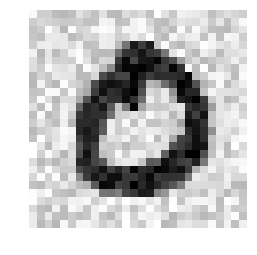

In [75]:
some_digit = X_test_mod[100]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')

<function matplotlib.pyplot.show(*args, **kw)>

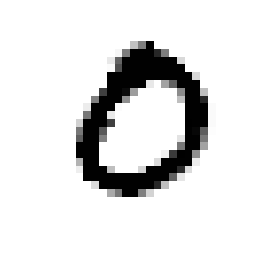

In [76]:
plt.imshow(clean_digit.reshape(28,28), cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show

In [79]:
#A dummy classifier
from sklearn.dummy import DummyClassifier

dmy_clf = DummyClassifier()
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method='predict_proba')
y_scores_dmy = y_probas_dmy[:, 1]

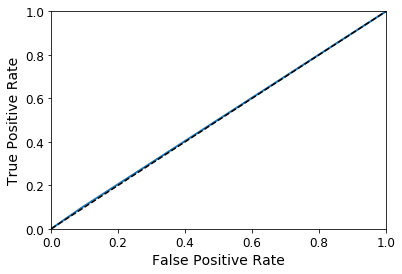

In [81]:
fprr, tprr, thesholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curver(fprr, tprr)

In [83]:
## KNN Classifier #Multicalss
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_jobs=3, weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=3, n_neighbors=4, p=2,
           weights='distance')

In [84]:
y_knn_pred = knn_clf.predict(X_test)

In [86]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_knn_pred)

0.9714

In [91]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

<function matplotlib.pyplot.show(*args, **kw)>

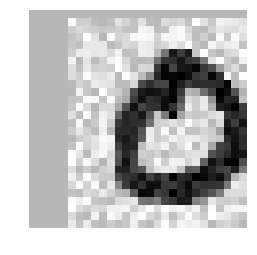

In [95]:
plt.imshow(shift_digit(some_digit, 5, 1, new=100).reshape(28,28), cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show

In [97]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]

for dx, dy in ((1,0),(-1,0),(0,1),(0,-1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)
    
X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [98]:
knn_clf.fit(X_train_expanded, y_train_expanded)
y_knn_expanded_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_knn_expanded_pred)

0.9763

In [99]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

array([[0.       , 0.       , 0.5053645, 0.       , 0.       , 0.       ,
        0.       , 0.4946355, 0.       , 0.       ]])

<function matplotlib.pyplot.show(*args, **kw)>

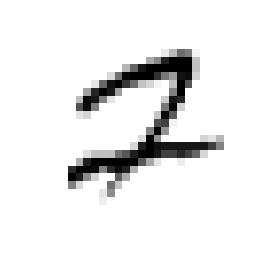

In [102]:
plt.imshow(ambiguous_digit.reshape(28,28), cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show

In [ ]:
#A model with over 97% accuracy 

from sklearn.model_selection import GridSearchCV

param_grid = [{'weights':['uniform', 'distance'], 'n_neighbors': [3,4,5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_expanded, y_train_expanded)